In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm, trange


np.random.seed(0)
torch.manual_seed(0)


### As we talked before, the inital input images need to be divided into small sub-blocks.A typical choice of the block size is 16x16, which is used in both initial visionTransformer Paper and the FPGA theis given to me. Definitely, the same for tiny-viT(i.e. tiny visionTransformer)

In [2]:
def patchify(images, n_patches):

  """
  Args:
  1. images: here the images is a variable having a batch type,it has 4 dimension: (batch,channel, height, width)
    batch -> number of images
    channel -> number of channels(i.e. rgb)
    height -> height of the image
    width -> width of the image
  2. n_patches: How many patches we would have

  """

  n, c, h, w = images.shape

  assert h == w, "Patchify method is implemented for square images only"

  # Here the variable patches has 3 dimension
  # (number_of_images, 2D_patch_dimension(i.e.16x16), how_many_patch_we_have)

  patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
  patch_size = h // n_patches

  # This for loop is the process of getting the final patching result
  # Each time the small image block is stored in the variable patch
  # Then we need to flatten the variable patch and let it stored in patches
  # step by step we stored the final patch result in variable patches and return it
  for idx, image in enumerate(images):
      for i in range(n_patches):
          for j in range(n_patches):
              patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
              patches[idx, i * n_patches + j] = patch.flatten()
  return patches

### Now we began to implement the multi-head-attention block. This is the core part of transformer block.(i.e.That green box in the figure)
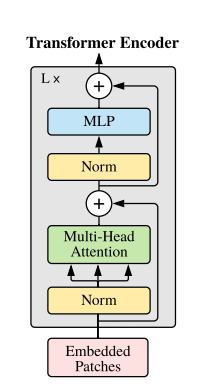

In [3]:
# self.d -> token dimension, which is also the second dimension of the embedded tokens. For tiny viT, it is set to 192 instead of 768
# self.n_head -> specify how many heads in the Multihead-self attention block. For tiny viT, it is 3 instead of 12

class MyMSA(nn.Module):
    def __init__(self, d, n_heads=3):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        # This is a process called mapping. Through this, we will get three learnalbe matrix q,k,v
        # q,k,v stand for query, key and value repectively. All these are nothing but vectors by the way
        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.k_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.v_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head : (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                # Mentioned in the thesis, the attention calculation output is purely Math
                # It is obtained by inner product of key and query devided the square root of length of vector. Then dot product with 'value' vector
                attention = self.softmax(q @ k.T / (self.d_head**0.5))
                seq_result.append(attention @ v)

            # There finally "merge" all the output from each head letting it comes back to the dimension (N, seq_length, token_dim)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

### Now we can fully process our transformer block. Again I put the figure here for the convinence

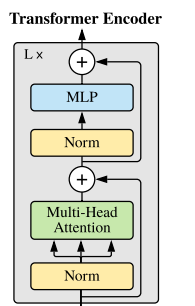

### TWO things that is worth noted:

### 1. The mlp is just the full connected layer. And the parameter mlp_ratio is just the factor of middle layer would magnifies the input. For tiny viT, it is the same as origin viT which is 4.

### 2. For the forward path, the formula : x + self.mhsa(self.norm1(x)). That is exactly the residual connection I mentioned before, which is the "add operation" on the figure.

In [4]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d),
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

### Now create a function to obtain the "position embedding" of each blocks. That is we need to "label" each blocks a position to let transformer know their relative relationship. Without this, the transformer will behave bad.

### The implementation of this is by using sin and cos function which I don't know why but just following the thesis.

In [5]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = (
                np.sin(i / (10000 ** (j / d)))
                if j % 2 == 0
                else np.cos(i / (10000 ** ((j - 1) / d)))
            )
    return result

### Overview:

### It is neccessary to wrap up our mind to get through the whole calculation processing again. Let's take an example here.

### eg. A image has 224x224x3 shape. Assume we want to use a 16x16 block to split it

### We will get the output from the embedding process(i.e. patchify):

### 224/16 * 224/16 = 196 blocks. Each block is a 16x16 RGB small images.Hence the output is 196 x (16x16x3) = 196 x 768

### For viT, we need two things more for our output. One is position embedding and one is classification embedding. Importantly, the classification embedding is concatenated with our output.(Hence our output is ((196+1)*768). The classification embedding parameters are set randomly at the beginning but is learnable during training. For position embedding parameters, it is directly added with the output. Hence doesn't change the dimension.

### The data will go through the linear projection processing first before sending it to transformer block. For tiny viT, after the linear projection, the output dimension will be 197 x 192 instead of 197x768 in the origin model.

### Then this 197x768 data will be sent to transformer block. The "Norm" block is just one of normalization(But layerNorm instead of BatchNorm we are familiar with). After that it will go to Multi-Head self-attention. As we mentioned before, after all the output being merged, the output of Multi-Head self-attention is the same as its input. Finally, going to MLP block, the middle layer in MLP will make the data to (197x4) x 192, but eventually the output will go back to 197 x 192. Hence we can see the final output of tranformer block will stay the same. This is the reason why we can cascade multiple transformer blocks one by one.

### Now we can begin to form our model architecture

In [21]:
### Attribute in MyVit:

### 1. chw -> dimension for image
### 2. n_patches -> the number of patches at row/column
### 3. n_blocks -> The number of cascaded transformer blocks we would have in our network
### 4. hidden_d -> The output dimension from the linear projection of the embedding data
### 5. n_head -> The number of head we would have in our multiHead-self attention block
### 6. out_d -> How many classes we have in our task

class MyViT(nn.Module):

    def __init__(self, chw, n_patches=14, n_blocks=12, hidden_d=192, n_heads=3, out_d=3):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw  # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer(
            "positional_embeddings",
            get_positional_embeddings(n_patches**2 + 1, hidden_d),
            persistent=False,
        )

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList(
            [MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)]
        )

        # 5) Classification MLPk
        self.mlp = nn.Linear(self.hidden_d, out_d)
        #self.mlp = nn.Sequential(nn.Linear(self.hidden_d, out_d), nn.Softmax(dim=-1))
    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out)  # Map to output dimension, output category distribution

### Now bring in a dataset to verify the code is correct or not

In [7]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [8]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 4356 (delta 213), reused 254 (delta 178), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 15.93 MiB/s, done.
Resolving deltas: 100% (2585/2585), done.
Updating files: 100% (248/248), done.


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [11]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [12]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [13]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

In [14]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

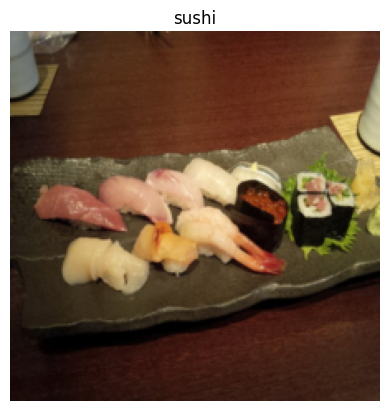

In [15]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [16]:
demo_img = torch.randn(1, 3, 224, 224).to(device)
print(demo_img.shape)

# Create ViT
vit = MyViT((3, 224, 224)).to(device)
vit(demo_img)

torch.Size([1, 3, 224, 224])


tensor([[0.3970, 0.4028, 0.2001]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [17]:
summary(model=MyViT(demo_img.shape[1:]))

Layer (type:depth-idx)                   Param #
MyViT                                    192
├─Linear: 1-1                            147,648
├─ModuleList: 1-2                        --
│    └─MyViTBlock: 2-1                   --
│    │    └─LayerNorm: 3-1               384
│    │    └─MyMSA: 3-2                   37,440
│    │    └─LayerNorm: 3-3               384
│    │    └─Sequential: 3-4              295,872
│    └─MyViTBlock: 2-2                   --
│    │    └─LayerNorm: 3-5               384
│    │    └─MyMSA: 3-6                   37,440
│    │    └─LayerNorm: 3-7               384
│    │    └─Sequential: 3-8              295,872
│    └─MyViTBlock: 2-3                   --
│    │    └─LayerNorm: 3-9               384
│    │    └─MyMSA: 3-10                  37,440
│    │    └─LayerNorm: 3-11              384
│    │    └─Sequential: 3-12             295,872
│    └─MyViTBlock: 2-4                   --
│    │    └─LayerNorm: 3-13              384
│    │    └─MyMSA: 3-14        

In [22]:
N_EPOCHS = 200
LR = 1e-5
model = MyViT((3, 224, 224)).to(device)

# Training loop
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_dataloader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

Training:   0%|          | 1/200 [00:10<35:04, 10.58s/it]

Epoch 1/200 loss: 1.31



Training:   1%|          | 2/200 [00:20<33:56, 10.28s/it]

Epoch 2/200 loss: 1.12



Training:   2%|▏         | 3/200 [00:30<33:14, 10.12s/it]

Epoch 3/200 loss: 1.11



Training:   2%|▏         | 4/200 [00:40<32:51, 10.06s/it]

Epoch 4/200 loss: 1.13



Training:   2%|▎         | 5/200 [00:50<32:52, 10.12s/it]

Epoch 5/200 loss: 1.17



Training:   3%|▎         | 6/200 [01:00<32:26, 10.04s/it]

Epoch 6/200 loss: 1.12



Training:   4%|▎         | 7/200 [01:10<32:05,  9.98s/it]

Epoch 7/200 loss: 1.09



Training:   4%|▍         | 8/200 [01:20<32:17, 10.09s/it]

Epoch 8/200 loss: 1.13



Training:   4%|▍         | 9/200 [01:31<32:21, 10.17s/it]

Epoch 9/200 loss: 1.15



Training:   5%|▌         | 10/200 [01:41<32:05, 10.13s/it]

Epoch 10/200 loss: 1.05



Training:   6%|▌         | 11/200 [01:51<31:48, 10.10s/it]

Epoch 11/200 loss: 1.17



Training:   6%|▌         | 12/200 [02:01<31:35, 10.08s/it]

Epoch 12/200 loss: 1.13



Training:   6%|▋         | 13/200 [02:11<31:28, 10.10s/it]

Epoch 13/200 loss: 1.11



Training:   7%|▋         | 14/200 [02:21<31:24, 10.13s/it]

Epoch 14/200 loss: 1.10



Training:   8%|▊         | 15/200 [02:31<31:08, 10.10s/it]

Epoch 15/200 loss: 1.11



Training:   8%|▊         | 15/200 [02:32<31:23, 10.18s/it]


KeyboardInterrupt: 